In [12]:
from tensorflow.keras.models import load_model
###### AE MODEL LOAD ######
ae_wo_classifier = load_model('model/AE_model/KERAS_check_best_model.h5')
ae_wo_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model.h5')
ae_w_classifier = load_model('model/AE_model/KERAS_check_best_model_classifier.h5')
ae_w_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model_classifier.h5')

In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)

qae_wo_classifier = load_model('model/QAE_model/KERAS_check_best_model.h5', custom_objects=co)
qae_wo_classifier_pruned = load_model('model/QAE_model/KERAS_check_pruned_best_model.h5', custom_objects=co)
qae_w_classifier = load_model('model/QAE_model/KERAS_check_best_model_classifier.h5', custom_objects=co)
qae_w_classifier_pruned = load_model('model/QAE_model/KERAS_check_pruned_best_model_classifier.h5', custom_objects=co)

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

In [24]:
w = qae_w_classifier_pruned.layers[10].weights[0].numpy()
print(w)

[[ 1.09893489e+00  1.34919703e+00 -1.08945742e-01  1.18162405e+00
  -4.88221312e+00 -9.04404283e-01 -3.22372079e+00  2.45152068e+00
   2.03548461e-01  6.46267354e-01]
 [ 8.58864009e-01 -1.90976429e+00  8.65204334e-02  1.15088761e+00
  -3.21435285e+00  1.98693204e+00  7.87147224e-01 -1.34608793e+00
  -2.99453050e-01 -1.01868145e-01]
 [ 1.40440679e-04 -2.04144162e-04 -1.98086782e-04 -1.32485984e-05
   2.10707622e-05 -2.03430012e-04 -1.44235237e-05 -6.23051164e-06
  -4.20870492e-07 -7.49968895e-05]
 [ 1.11245468e-01  1.10917747e+00 -2.95153242e-02 -6.30209595e-02
   5.90066671e-01 -1.06448257e+00  1.25119185e+00 -2.21502399e+00
   2.31679469e-01 -1.42425904e-03]
 [-3.31831211e-03  1.00794661e+00 -1.01066334e-02 -1.01668870e+00
   4.09806311e-01 -1.43602133e+00  1.22483826e+00 -1.86940134e+00
   9.55081359e-02 -8.50413799e-01]
 [-7.99887478e-01 -1.95529747e+00  2.09273435e-02  9.22989607e-01
   2.11714551e-01  6.16716921e-01  7.46967643e-02 -2.33469218e-01
   3.03790485e-03 -1.04450412e-01

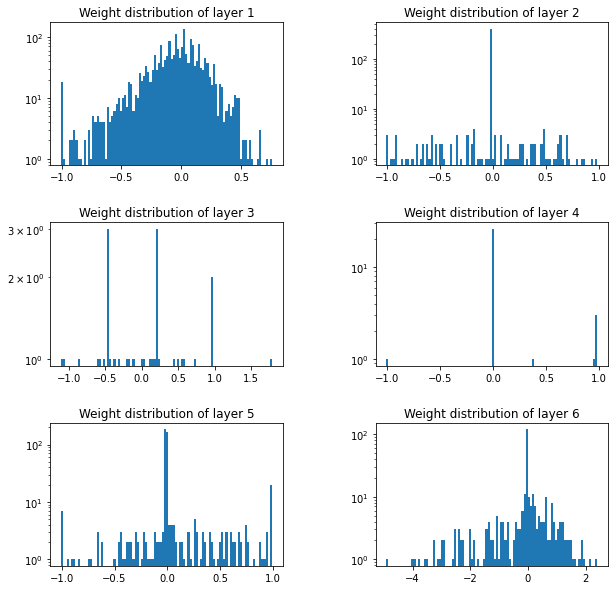

In [27]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 3
fig.subplots_adjust(hspace=0.4, wspace=0.4)

#this applies for the quantized loop
num_layers = [1,3,5,6,8,10]#,11,14,15]
j = 1

for i in num_layers:
#for i in range(1, columns*rows +1):  
    fig.add_subplot(rows, columns, j)
    w = qae_w_classifier_pruned.layers[i].weights[0].numpy()
    h, b = np.histogram(w, bins=100)
    plt.bar(b[:-1], h, width=b[1]-b[0])
    plt.semilogy()
    plt.title('Weight distribution of layer '+ str(j))
    j += 1

#plt.savefig('./Report/images/section4/pruned_weightsdistr.png')
plt.show()


# Make an hls4ml config & model

In [4]:
import plotting
import hls4ml
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(qae_w_classifier_pruned, granularity='name')
config['LayerName']['encoder_input']['Precision']='ap_fixed<6,0>'

#config['LayerName']['classifier_output']['Precision'] = 'ap_fixed<32,12>'
config['LayerName']['classifier_output']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['classifier_output']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(qae_w_classifier_pruned,
                                                       hls_config=config,
                                                       output_dir='model/QAE_model/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')
                                                       #part='xcvu9p-flgc2104aaz')
                                                       #part='xc7vx690t-ffg176-2')


C:\Users\loren\miniconda3\lib\site-packages\hls4ml\converters\__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


Interpreting Model
Topology:
Layer name: encoder_input, layer type: Input
Layer name: fc1, layer type: QDense
Layer name: relu1, layer type: QActivation
Layer name: fc2_prun, layer type: QDense
Layer name: relu2, layer type: QActivation
Layer name: encoder_output, layer type: Dense
  -> Activation (relu), layer name: encoder_output
Layer name: fc4_prunedclass, layer type: QDense
Layer name: prunclass_relu4, layer type: QActivation
Layer name: fc5_class, layer type: QDense
Layer name: class_relu5, layer type: QActivation
Layer name: classifier_out, layer type: QDense
Layer name: classifier_output, layer type: Activation
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  encoder_input
    Precision:       ap_fixed<6,0>
  fc1
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    ReuseFactor:     1
  relu1
    Precision
      result:        ap_ufixed<5,0>
    ReuseFa

# Compile

In [5]:
hls_model.compile()

Writing HLS project
Done


Exception: Failed to compile project "myproject"

# Build

In [23]:
hls_model.build(csim=True, cosim=True)

Project myproject_prj does not exist. Rerun "hls4ml build -p model/QAE_model/hls4ml_prj".


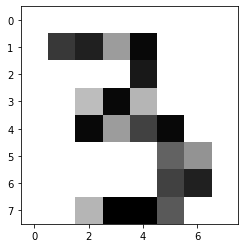

In [33]:
import MNIST_dataset as mnist

#Choose the final size of your image dataset
size_final = 8

data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)

from matplotlib import pyplot as plt

#           0  1  2  3  4  5  6  7  8  9          
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12] 

ax = plt.subplot(1, 1 , 1)
img = data_zoom.x_test[32].reshape(1,-1)

plt.imshow(img.reshape(size_final,size_final), cmap='gray_r')

In [34]:
import time
import numpy as np
start_time = time.time()
out = qae_w_classifier_pruned.predict(img)
print("--- %s seconds ---" % (time.time() - start_time))
print(out)
print(np.sum(out))

--- 0.0641179084777832 seconds ---
[[1.0493946e-05 8.7776874e-07 1.1448536e-04 9.3670255e-01 3.8663514e-02
  2.2790924e-02 3.3426222e-06 5.6316128e-07 2.6797960e-04 1.4452839e-03]]
1.0


In [7]:
y = hls_model.predict(img)[1]


Exception: Model not compiled